In [1]:
import pandas as pd  # noqa
import matplotlib.pyplot as plt  # type: ignore
import seaborn as sns  # type: ignore
from collections import defaultdict
from tasks_support_system_ai.utils import get_correct_data_path
from tasks_support_system_ai.readers import (
    read_ts_tree,
    ts_read_daily_tickets,
    get_map_parent_to_children_queues,
)

In [2]:
df = ts_read_daily_tickets(get_correct_data_path("tickets_daily/tickets_daily.csv"))
tree = read_ts_tree(get_correct_data_path("dataset_tickets_timeseries/tree_queue.tsv"))

In [3]:
df.head()

,queueId,date,new_tickets
0,1,2017-01-01,15
1,1,2017-01-02,26
2,1,2017-01-03,25
3,1,2017-01-04,29
4,1,2017-01-05,26


In [4]:
df.shape

(418327, 3)

In [5]:
tree.head()

,parentQueueId,childrenIds
0,2010,"[2330, 2010]"
1,1571,"[3085, 1571]"
2,100153,"[3546, 100153, 2732, 1162, 100113, 2980, 3810,..."
3,2538,"[3252, 2583, 2538]"
4,100192,"[100193, 100192]"


In [6]:
tree.shape

(337, 2)

Некоторые очереди только существуют в `childrenIds`, но не в `parentQueueId`

In [7]:
all_queues = set(df.queueId.unique())
len(all_queues)

828

In [8]:
tree.shape

(337, 2)

Да, может, не все очереди в `parentQueueId` попадают

### Сколько выпавших очередей

In [9]:
all_queues_in_hierarchy = set()


def update_queues_hierarchy(row):
    all_queues_in_hierarchy.add(row["parentQueueId"])
    for children in row["childrenIds"]:
        all_queues_in_hierarchy.add(children)


tree.apply(update_queues_hierarchy, axis=1)
None

In [10]:
queues_not_in_hierarchy = all_queues - all_queues_in_hierarchy
print(
    f"В данных на {len(queues_not_in_hierarchy)} больше очередей, чем в иерархии.\nВ иерархии {len(all_queues_in_hierarchy)} очередей."
)

В данных на 346 больше очередей, чем в иерархии.
В иерархии 1651 очередей.


пример

In [11]:
print(list(queues_not_in_hierarchy)[:10])

[100353, 100354, 100355, 100356, 100357, 100365, 100401, 100404, 100407, 100408]


### Насколько потерянные очереди большие

In [12]:
df_extra_queue = (
    df[df.queueId.isin(queues_not_in_hierarchy)]
    .groupby("queueId")["new_tickets"]
    .sum()
    .sort_values(ascending=False)
)
df_extra_queue[:10]

queueId
100644    225158
100814     63307
100404     43099
100751     34374
100907     34271
100571     31174
100869     29974
100919     29759
100895     25059
100815     24915
Name: new_tickets, dtype: int64

In [13]:
print(f"extra tickets: {df_extra_queue.sum() / df['new_tickets'].sum():.2%}")

extra tickets: 8.03%


Видна выпавшая из иерархии очередь `100644`

In [14]:
(df.groupby("queueId")["new_tickets"].sum().sort_values(ascending=False))[:10]

queueId
1866      495259
3232      483591
3730      315986
3836      244251
2709      235990
25        233598
3602      230378
100644    225158
2200      224805
29        216448
Name: new_tickets, dtype: int64

### Анализ иерархии очередей

In [15]:
def get_depth(queue_id, visited=None):
    if visited is None:
        visited = set()
    if queue_id in visited:
        return 0
    visited.add(queue_id)
    children = tree[tree["parentQueueId"] == queue_id]["childrenIds"].values
    if len(children) == 0:
        return 1
    return 1 + max(get_depth(child, visited.copy()) for child in children[0])


tree["depth"] = tree["parentQueueId"].apply(get_depth)

In [16]:
tree["depth"].describe().round(3)

count    337.000
mean       2.371
std        0.784
min        1.000
25%        2.000
50%        2.000
75%        2.000
max        6.000
Name: depth, dtype: float64

In [17]:
tree[tree["depth"] == 1]

,parentQueueId,childrenIds,depth
16,100281,[100281],1
306,100307,[100307],1


In [18]:
tree[tree["depth"] == 2].head()

,parentQueueId,childrenIds,depth
0,2010,"[2330, 2010]",2
1,1571,"[3085, 1571]",2
2,100153,"[3546, 100153, 2732, 1162, 100113, 2980, 3810,...",2
3,2538,"[3252, 2583, 2538]",2
4,100192,"[100193, 100192]",2


In [19]:
tree[tree["depth"] == 6]

,parentQueueId,childrenIds,depth
25,2034,"[2713, 2100, 2327, 2326, 2329, 2328, 2079, 266...",6
35,2870,"[211, 2653, 2651, 2650, 2654, 3048, 3047, 3556...",6
150,742,"[3715, 2964, 3496, 1262, 2840, 26, 691, 1142, ...",6
176,2299,"[2717, 2846, 2842, 2843, 3410, 2320, 2480, 248...",6


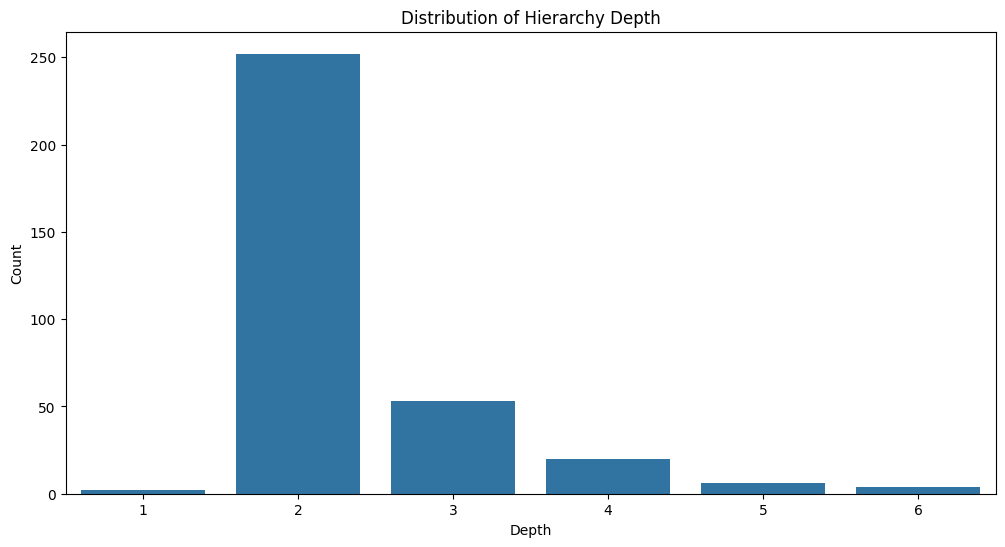

In [20]:
plt.figure(figsize=(12, 6))
depth_counts = tree["depth"].value_counts().sort_index()
sns.barplot(x=depth_counts.index, y=depth_counts.values)
plt.title("Distribution of Hierarchy Depth")
plt.xlabel("Depth")
plt.ylabel("Count")
plt.show()

In [21]:
queue_to_all_children = get_map_parent_to_children_queues(tree)

In [22]:
print(f'Всего тикетов: {df['new_tickets'].sum():,}')

Всего тикетов: 15,440,382


### Топ очередей (включая всю иерархию)

In [23]:
total_counts = defaultdict(int)

for queue_id, children in queue_to_all_children.items():
    count = df[df["queueId"].isin(children)]["new_tickets"].sum()
    total_counts[queue_id] = count

sorted_counts = sorted(total_counts.items(), key=lambda x: x[1], reverse=True)

top_10_queues = sorted_counts[:10]

for queue_id, count in top_10_queues:
    print(f"Queue {queue_id}: {count:,}")

Queue 10: 2,463,146
Queue 742: 1,619,592
Queue 1866: 1,470,013
Queue 1871: 1,354,349
Queue 34: 1,247,019
Queue 2657: 1,243,017
Queue 4447: 1,121,534
Queue 4397: 986,415
Queue 115: 896,296
Queue 2002: 825,237
